## 0) Environment / Imports

In [ ]:
import os
import sys

# Set CUDA_VISIBLE_DEVICES before importing torch
if 'torch' in sys.modules:
    print("WARNING: 'torch' is already imported; CUDA_VISIBLE_DEVICES change will NOT take effect.")
    print("Please restart the kernel and run this cell first if you need to change GPUs.")
else:
    os.environ.setdefault('CUDA_VISIBLE_DEVICES', '0')
    print('CUDA_VISIBLE_DEVICES =', os.environ['CUDA_VISIBLE_DEVICES'])

CUDA_VISIBLE_DEVICES = 3


In [2]:

import copy
import gc
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
import mpl_toolkits.axisartist as axisartist
from typing import Dict, List, Optional

from decord import VideoReader, cpu
from PIL import Image

# Ensure working directory is project root
if os.getcwd().endswith('visualize'):
    os.chdir('..')
    print('Changed working directory to:', os.getcwd())

assert os.path.exists('./ckpts'), f"./ckpts not found (cwd={os.getcwd()})"
sys.path.append(os.getcwd())

plt.rcParams.update({
    'font.family': 'DejaVu Serif',
    'axes.unicode_minus': False,
})

Changed working directory to: /workspace/images-starfs/workspace/xuboshen/code/timeviper


## 1) Config

In [ ]:
MODEL_CKPT = 'TimeViper-9B-w/TransV'
LLM_BACKBONE_ID = 'nano-9b-v2-base'
ARCH_SPECIFIER = 'no-align-16-+tome_mlp'

VIDEO_PATH = 'assets/ytb__-8dY8tUGhw.mp4'
PROMPT = 'Describe the main action in this video.'

# example parameters
MAX_FRAMES = 8
MAX_NEW_TOKENS = 25

# Output
OUTPUT_DIR = './output/attention_sink_cookbook_clean'
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEFAULT_TOKEN = '<image>'

# Device selection
# - If CUDA_VISIBLE_DEVICES is set, torch sees 1 GPU and we should use cuda:0
# - Otherwise you can manually choose here
DEVICE = 'cuda:0' if torch.cuda.device_count() == 1 else 'cuda:3'
print('torch.cuda.device_count() =', torch.cuda.device_count())
print('Using DEVICE =', DEVICE)

assert os.path.exists(MODEL_CKPT), f'MODEL_CKPT not found: {MODEL_CKPT}'
assert os.path.exists(VIDEO_PATH), f'VIDEO_PATH not found: {VIDEO_PATH}'

torch.cuda.device_count() = 1
Using DEVICE = cuda:0


## 2) Model + Processor

In [4]:
from visualize.nano import modeling_nano
from models.timeviper.llm.llm_registry import MODEL_REGISTRY

MODEL_REGISTRY['nano']['llm_cls'] = modeling_nano.NemotronHForCausalLM
MODEL_REGISTRY['nano']['layer_cls'] = modeling_nano.NemotronHBlock

from models.timeviper import get_llm_backbone_and_tokenizer, get_vision_backbone_and_transform
from models.timeviper.vlms import HybridTimeViperVLM
from models.timeviper.image_processing import ImageProcessor
from models.timeviper.processing_qwen2_vl import TimeViperVLProcessor
from models.conversation import conv_nano_base

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully registered 'NemotronHEagerAttention' with key 'eager_manual'.
[2026-01-04 16:06:10,091] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


01/04 [16:06:10] INFO     | >> x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g       ]8;id=510705;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=115876;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat                                   
                          -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpyhm0q6xs/test.c -o               
                          /tmp/tmpyhm0q6xs/test.o                                                                  

                 INFO     | >> x86_64-linux-gnu-gcc /tmp/tmpyhm0q6xs/test.o -laio -o                    ]8;id=13229;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=104060;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          /tmp/tmpyhm0q6xs/a.out                                                                   

/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


01/04 [16:06:11] INFO     | >> x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g       ]8;id=880894;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=126268;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat                                   
                          -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmpzbi8fsfo/test.c -o               
                          /tmp/tmpzbi8fsfo/test.o                                                                  

                 INFO     | >> x86_64-linux-gnu-gcc /tmp/tmpzbi8fsfo/test.o -L/usr/local/cuda           ]8;id=991365;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=734793;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          -L/usr/local/cuda/lib64 -lcufile -o /tmp/tmpzbi8fsfo/a.out                               

                 INFO     | >> x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g       ]8;id=937706;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=580009;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat                                   
                          -Werror=format-security -g -fwrapv -O2 -fPIC -c /tmp/tmphck7jjgx/test.c -o               
                          /tmp/tmphck7jjgx/test.o                                                                  

                 INFO     | >> x86_64-linux-gnu-gcc /tmp/tmphck7jjgx/test.o -laio -o                    ]8;id=872150;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py\spawn.py]8;;\:]8;id=750937;file:///usr/local/lib/python3.10/dist-packages/setuptools/_distutils/spawn.py#77\77]8;;\
                          /tmp/tmphck7jjgx/a.out                                                                   

/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2026-01-04 16:06:15,080] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [5]:
# Memory hygiene
if 'model' in globals():
    del model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print('Building vision backbone...')
vision_backbone, image_transform = get_vision_backbone_and_transform(
    'siglip-vit-so400m-384px', image_resize_strategy='resize-naive'
)

print('Building LLM backbone...')
llm_backbone, _tok = get_llm_backbone_and_tokenizer(
    LLM_BACKBONE_ID,
    llm_max_length=4096,
    attn_implementation='eager',
)

print('Loading VLM checkpoint...')
model = HybridTimeViperVLM.from_pretrained(
    pretrained_checkpoint=MODEL_CKPT,
    model_id='nano-vlm',
    vision_backbone=vision_backbone,
    llm_backbone=llm_backbone,
    arch_specifier=ARCH_SPECIFIER,
).to(DEVICE)
model.eval()

image_processor = ImageProcessor(patch_size=14, image_transforms=image_transform)
processor = TimeViperVLProcessor(image_processor, _tok, model_config=model.config)
tokenizer = processor.tokenizer

num_layers = model.llm_backbone.llm.config.num_hidden_layers
num_vision_tokens_per_image = model.projector.num_compressed_tokens
print('num_layers =', num_layers)
print('num_vision_tokens_per_image =', num_vision_tokens_per_image)

Building vision backbone...
Loaded pretrained SigLIP ViT Backbone from ./ckpts/vit_so400m_patch14_siglip_384.pth
Building LLM backbone...


01/04 [16:06:31] INFO     | >>     |=> Loading nano LLM from                                      ]8;id=390789;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py\llm_factory.py]8;;\:]8;id=740204;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py#81\81]8;;\
                          `nvidia/NVIDIA-Nemotron-Nano-9B-v2-Base`                                                 

                 INFO     | >>         |=> Loading model weights from                             ]8;id=624487;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py\llm_factory.py]8;;\:]8;id=924742;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py#89\89]8;;\
                          ./ckpts/NVIDIA-Nemotron-Nano-9B-v2-Base                                                  

Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


01/04 [16:06:43] INFO     | >>     |=> Loading nano (Fast) Tokenizer via the AutoTokenizer API   ]8;id=303317;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py\llm_factory.py]8;;\:]8;id=240376;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/llm/llm_factory.py#138\138]8;;\

Loading VLM checkpoint...


01/04 [16:06:44] INFO     | >> [*] Using positional encoding of type: None                        ]8;id=859863;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/vlms/generic_vlm.py\generic_vlm.py]8;;\:]8;id=530019;file:///workspace/images-starfs/workspace/xuboshen/code/timeviper/models/timeviper/vlms/generic_vlm.py#97\97]8;;\

num_layers = 56
num_vision_tokens_per_image = 16


## 3) Run One Example (collect attentions)

In [6]:
def load_video_frames(video_path: str, max_frames: int) -> List[Image.Image]:
    vr = VideoReader(video_path, ctx=cpu(0))
    idx = np.linspace(0, len(vr) - 1, max_frames, dtype=int)
    return [Image.fromarray(vr[i].asnumpy()) for i in idx]

def build_prompt(frames: List[Image.Image], prompt: str) -> str:
    conv = conv_nano_base.copy()
    conv.messages = []
    token = DEFAULT_TOKEN * len(frames)
    text_prompt = f"{token}\n{prompt}"
    conv.append_message(conv.roles[0], text_prompt)
    conv.append_message(conv.roles[1], None)
    return conv.get_prompt()

frames = load_video_frames(VIDEO_PATH, MAX_FRAMES)
prompt_str = build_prompt(frames, PROMPT)

encoding = processor(prompt_str, images=[frames], return_tensors='pt')
input_ids = encoding['input_ids'].to(DEVICE)
pixel_values_videos = encoding['pixel_values_videos'].to(DEVICE, dtype=model.dtype)

num_images = (input_ids == tokenizer.convert_tokens_to_ids(DEFAULT_TOKEN)).sum().item()
total_vision_tokens = num_images * num_vision_tokens_per_image
print('num_images =', num_images, 'total_vision_tokens =', total_vision_tokens)

with torch.no_grad():
    outputs = model.generate(
        input_ids=input_ids,
        pixel_values_videos=pixel_values_videos,
        max_new_tokens=MAX_NEW_TOKENS,
        do_sample=False,
        return_dict_in_generate=True,
        output_attentions=True,
        use_cache=False,
        eos_token_id=tokenizer.eos_token_id,
    )

generated_ids = outputs.sequences
generated_text = tokenizer.decode(generated_ids[0, input_ids.shape[1]:], skip_special_tokens=True)
print('Generated:', generated_text.strip())

assert outputs.attentions is not None and len(outputs.attentions) > 0, 'No attentions returned.'
final_step_attentions = outputs.attentions[-1]
print('Final-step layers =', len(final_step_attentions))

num_images = 8 total_vision_tokens = 128
Generated: The main action is the person explaining the functionality of a fireplace control panel and demonstrating how to use it.
Assistant
Final-step layers = 56


## 4) Token Ranges (instruction / vision / response)

In [7]:
def identify_token_types(
    original_prompt_ids: torch.Tensor,
    vision_placeholder_index: int,
    num_vision_tokens: int,
    total_sequence_length: int,
    generated_length: int,
) -> Dict[str, List[int]]:
    token_positions = {'instruction': [], 'vision': [], 'response': []}

    response_start = total_sequence_length - generated_length
    token_positions['response'] = list(range(response_start, total_sequence_length))

    vision_start = vision_placeholder_index
    vision_end = vision_start + num_vision_tokens

    token_positions['instruction'].extend(range(0, vision_start))
    token_positions['vision'].extend(range(vision_start, vision_end))
    token_positions['instruction'].extend(range(vision_end, response_start))

    return token_positions

# Infer actual sequence length from attention tensor shape
actual_seq_len = None
for layer_attn in final_step_attentions:
    attn = layer_attn[0] if isinstance(layer_attn, tuple) and len(layer_attn) == 2 else layer_attn
    if attn is not None:
        actual_seq_len = attn.shape[-1] + 1
        break
if actual_seq_len is None:
    actual_seq_len = int(generated_ids.shape[1])

generated_length = int(generated_ids.shape[1] - input_ids.shape[1])
image_token_id = tokenizer.convert_tokens_to_ids(DEFAULT_TOKEN)
vision_placeholder_index = input_ids[0].tolist().index(image_token_id)

token_positions = identify_token_types(
    input_ids[0],
    vision_placeholder_index,
    total_vision_tokens,
    actual_seq_len,
    generated_length,
)

print({k: (v[0], v[-1], len(v)) if v else None for k, v in token_positions.items()})

{'instruction': (0, 149, 22), 'vision': (8, 135, 128), 'response': (150, 174, 25)}


## 5) Plot Helpers (ported from visualize.ipynb)

In [8]:
def normalize_mamba_attentions(attentions: tuple) -> tuple:
    # Only normalizes layers that are stored as (tensor, 'mamba')
    attentions = copy.deepcopy(attentions)
    out = []
    for item in attentions:
        is_mamba = isinstance(item, tuple) and len(item) == 2 and item[1] == 'mamba'
        if not is_mamba:
            out.append(item)
            continue
        attn_tensor, layer_type = item
        if attn_tensor is None:
            out.append((None, layer_type))
            continue
        device = attn_tensor.device
        dtype = attn_tensor.dtype
        attn_np = attn_tensor.detach().cpu().float().numpy()
        l1 = np.abs(attn_np).sum(axis=-1, keepdims=True)
        l1[l1 == 0] = 1.0
        attn_np = attn_np / l1
        out.append((torch.from_numpy(attn_np).to(device=device, dtype=dtype), layer_type))
    return tuple(out)

def plot_sub_attention_map(
    ax: plt.Axes,
    cmap: mpl.colors.Colormap,
    all_attentions: tuple,
    layer_idx: int,
    head_idx: Optional[int] = None,
    max_tokens: Optional[int] = None,
    ignore_diagonal: bool = False,
    vmax_type: str = 'max',
    vmax_value: float = 1.0,
    use_log_scale: bool = False,
    title: Optional[str] = None,
    token_boundaries: Optional[List[int]] = None,
    show_colorbar: bool = False,
):
    MIN = 1e-6 if use_log_scale else 0
    cmap.set_bad(color='#ffffff')

    layer_attention = all_attentions[layer_idx]
    if isinstance(layer_attention, tuple) and len(layer_attention) == 2:
        layer_attention = layer_attention[0]

    if layer_attention.dim() == 4:
        if head_idx is None:
            head_attention = layer_attention[0].mean(dim=0).cpu().float().numpy()
        else:
            head_attention = layer_attention[0, head_idx].cpu().float().numpy()
    else:
        if head_idx is None:
            head_attention = layer_attention.mean(dim=0).cpu().float().numpy()
        else:
            head_attention = layer_attention[head_idx].cpu().float().numpy()

    head_attention = np.abs(head_attention)
    if max_tokens is not None and head_attention.shape[0] > max_tokens:
        head_attention = head_attention[:max_tokens, :max_tokens]

    masked = head_attention.copy()
    if ignore_diagonal:
        np.fill_diagonal(masked, 0)
    mask = np.triu(np.ones_like(masked, dtype=bool), k=1)
    masked[mask] = 0

    if vmax_type == 'max':
        vmax = min(masked.max(), vmax_value)
        vmin = max(masked.min(), MIN)
    elif vmax_type == 'raw':
        vmin = MIN
        vmax = vmax_value
    else:
        raise ValueError(vmax_type)

    masked[mask] = np.nan
    if ignore_diagonal:
        np.fill_diagonal(masked, np.nan)
    if use_log_scale:
        masked[masked < MIN] = MIN

    im = ax.imshow(
        masked,
        cmap=cmap,
        norm='log' if use_log_scale else None,
        vmin=vmin,
        vmax=vmax,
        interpolation='none',
        aspect='equal',
    )

    if token_boundaries is not None:
        color = '#ffffff'
        ymax = masked.shape[0] - 1
        for idx in token_boundaries:
            ax.plot([idx, idx], [idx, ymax], color=color, linewidth=1.5)
            ax.plot([0, idx], [idx, idx], color=color, linewidth=1.5)

    if title is None:
        title = f'Layer {layer_idx} (Avg)' if head_idx is None else f'Layer {layer_idx} Head {head_idx}'
    ax.set_title(title)

    ax.axis('tight')
    ax.set_box_aspect(1)
    ax.tick_params(axis='both', which='both', length=0, pad=3)
    ax.xaxis.set_major_locator(MaxNLocator(4, steps=[1, 5, 10]))
    ax.yaxis.set_major_locator(MaxNLocator(4, steps=[1, 5, 10]))
    for spine in ax.spines.values():
        spine.set_visible(False)

    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(length=0, width=0)
        cbar.ax.yaxis.set_minor_locator(plt.NullLocator())
        pos = ax.get_position()
        cbar.ax.set_position([pos.x1 + 0.005, pos.y0, 0.015, pos.height])

    return im

def compute_attention_variation(attentions: tuple, token_positions: Dict[str, List[int]]) -> Dict[str, np.ndarray]:
    token_positions = {k: v.copy() for k, v in token_positions.items()}
    if token_positions.get('response'):
        token_positions['response'].pop(-1)  # last token has no attention

    attention_types = [
        ('instruction', 'instruction', 'i2i'),
        ('instruction', 'vision', 'i2v'),
        ('vision', 'instruction', 'v2i'),
        ('vision', 'vision', 'v2v'),
        ('response', 'instruction', 'r2i'),
        ('response', 'vision', 'r2v'),
        ('response', 'response', 'r2r'),
    ]

    out = {name: np.full(len(attentions), np.nan) for *_unused, name in attention_types}

    for layer_idx in range(len(attentions)):
        attn_item = attentions[layer_idx]
        attn_tensor = attn_item[0] if isinstance(attn_item, tuple) and len(attn_item) == 2 else attn_item
        if attn_tensor is None:
            continue

        layer_np = attn_tensor[0].detach().cpu().float().numpy() if attn_tensor.dim() == 4 else attn_tensor.detach().cpu().float().numpy()
        layer_np = np.abs(layer_np)
        if layer_np.ndim == 3:
            layer_np = layer_np.mean(axis=0)

        for from_type, to_type, name in attention_types:
            from_pos = token_positions.get(from_type, [])
            to_pos = token_positions.get(to_type, [])
            if not from_pos or not to_pos:
                out[name][layer_idx] = 0.0
                continue
            sub = layer_np[from_pos, :][:, to_pos]
            sum_per_from = sub.sum(axis=1)
            denom = (sum_per_from > 0).sum()
            out[name][layer_idx] = float(sum_per_from.sum() / denom) if denom > 0 else 0.0

    return out

def plot_attention_variation(
    ax: plt.Axes,
    attention_variation: Dict[str, np.ndarray],
    layers: List[int],
    patterns: Dict[str, Dict[str, str]],
    xticks: Optional[List[int]] = None,
    title: Optional[str] = None,
    xlabel: str = '',
    ylabel: str = '',
    **kwargs,
):
    layers = np.array(layers)
    sliced = {k: v[layers] for k, v in attention_variation.items()}

    handles = []
    for pattern, cfg in patterns.items():
        if pattern in sliced:
            vals = sliced[pattern]
        else:
            # allow composite keys like 'ivr2i' meaning mean of i2i/v2i/r2i
            from_types, to_types = pattern.split('2')
            bucket = []
            for f in from_types:
                for t in to_types:
                    bucket.append(sliced[f'{f}2{t}'])
            vals = np.mean(bucket, axis=0)

        valid = ~np.isnan(vals)
        if not np.any(valid):
            continue
        (line,) = ax.plot(layers[valid], vals[valid], color=cfg['color'], marker=cfg.get('marker', 'o'), label=cfg['label'], **kwargs)
        handles.append(line)

    ax.axis['top'].set_visible(False)
    ax.axis['right'].set_visible(False)
    ax.axis['bottom'].set_axisline_style('-|>', size=1)
    ax.axis['left'].set_axisline_style('-|>', size=1)
    ax.axis['bottom'].line.set_linewidth(2.5)
    ax.axis['left'].line.set_linewidth(2.5)
    ax.tick_params(axis='both', length=0, width=0)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title, fontweight='bold')
    ax.set_ylim(0, 1)
    if xticks is not None:
        ax.set_xticks(xticks)

    return handles

## 6) Fig5 — Attention Matrices (Nano)

Saved: ./output_novocab/attention_sink_cookbook_clean/fig5-matrix-nano.png


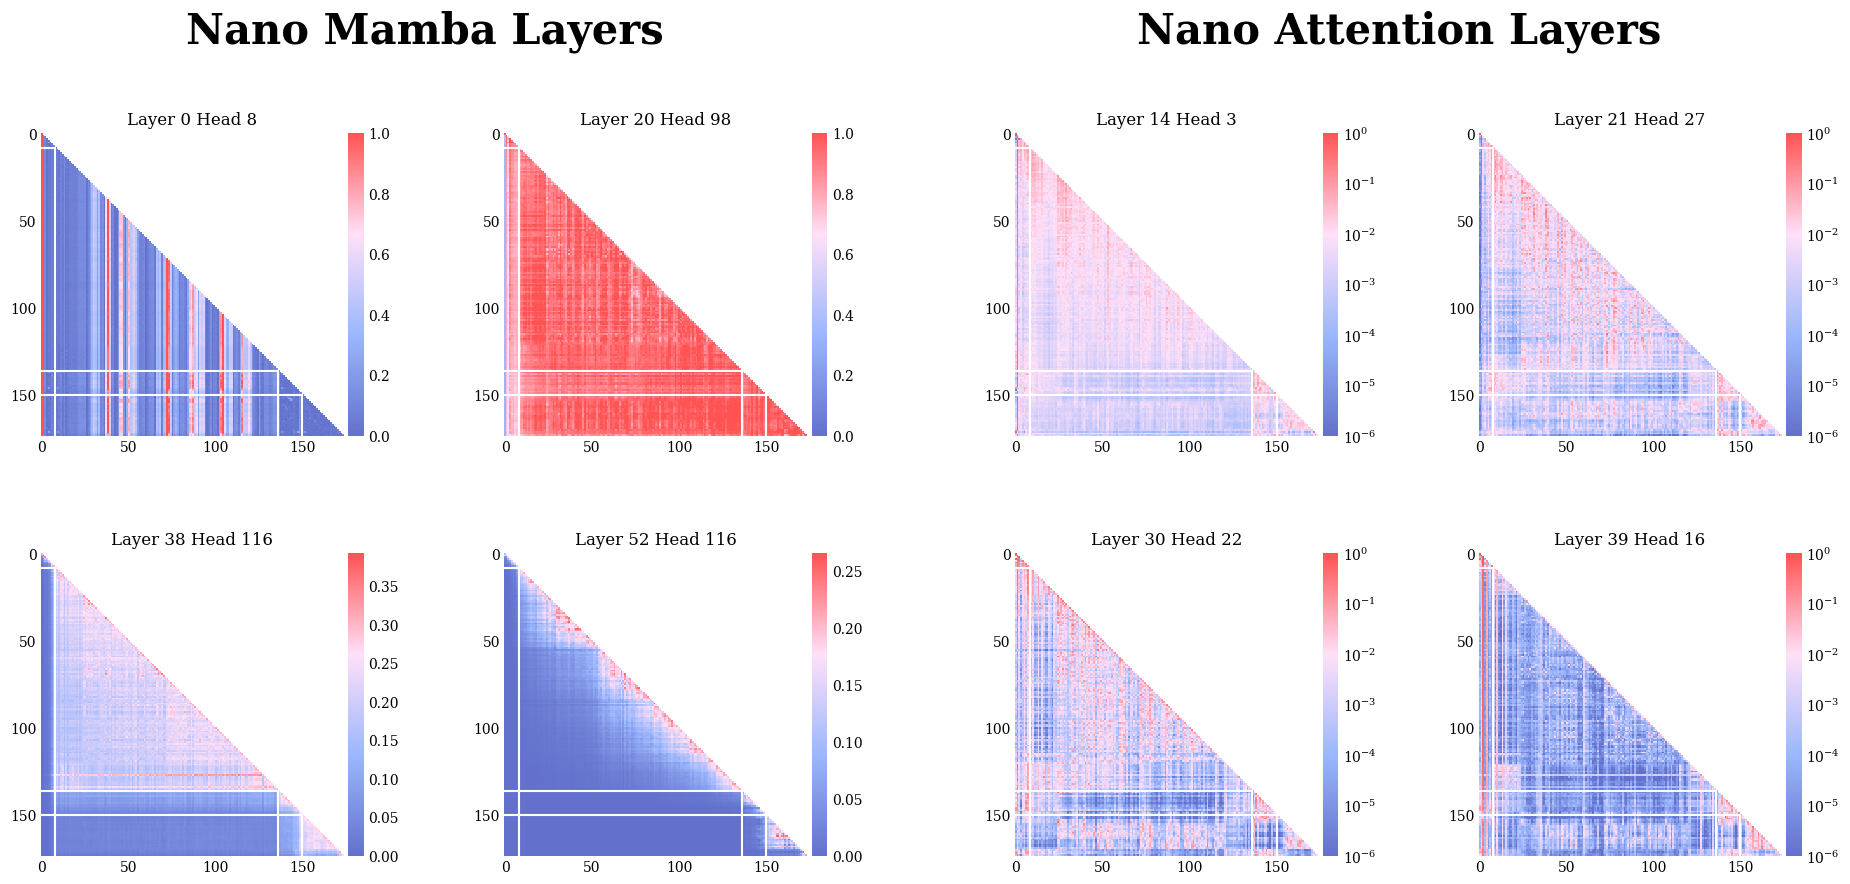

In [9]:
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#6371CC', '#9BB7FD', '#FFE0F8', '#ff5353'], N=256
)

def get_token_boundaries(tp: Dict[str, List[int]]) -> List[int]:
    return [tp['vision'][0], tp['vision'][-1] + 1, tp['response'][0]]

data_config = [
    {
        'title': 'Nano Mamba Layers',
        'layer_heads': [(0, 8), (20, 98), (38, 116), (52, 116)],
        'use_log_scale': False,
        'vmax_type': 'max',
    },
    {
        'title': 'Nano Attention Layers',
        'layer_heads': [(14, 3), (21, 27), (30, 22), (39, 16)],
        'use_log_scale': True,
        'vmax_type': 'raw',
    },
]

fig = plt.figure(figsize=(20, 10))
subfigs = fig.subfigures(1, len(data_config), wspace=-0.05)
if len(data_config) == 1:
    subfigs = [subfigs]

for subfig, cfg in zip(subfigs, data_config):
    axs = subfig.subplots(2, 2, gridspec_kw={'wspace': 0.4, 'hspace': 0.2}).flatten()
    for ax, (layer_idx, head_idx) in zip(axs, cfg['layer_heads']):
        plot_sub_attention_map(
            ax,
            cmap,
            final_step_attentions,
            layer_idx,
            head_idx,
            use_log_scale=cfg['use_log_scale'],
            vmax_type=cfg['vmax_type'],
            vmax_value=1,
            token_boundaries=get_token_boundaries(token_positions),
            show_colorbar=True,
            ignore_diagonal=False,
        )
    subfig.suptitle(cfg['title'], fontsize=30, fontweight='bold', y=0.98)

out_path = os.path.join(OUTPUT_DIR, 'fig5-matrix-nano.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print('Saved:', out_path)

## 7) Fig6 — Attention Variation (Nano)

Saved: ./output_novocab/attention_sink_cookbook_clean/fig6-variation-nano.png


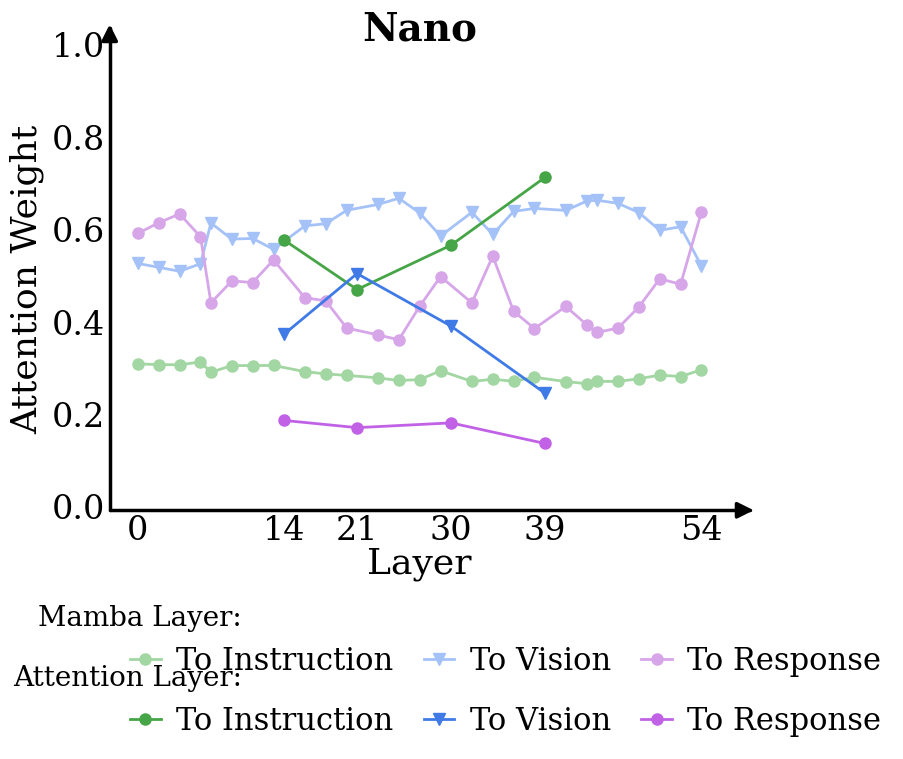

In [10]:
normed_attn = normalize_mamba_attentions(final_step_attentions)
variation = compute_attention_variation(normed_attn, token_positions)

plt.rcParams.update({
    'font.family': 'DejaVu Serif',
    'font.size': 22,
    'axes.titlesize': 28,
    'axes.labelsize': 26,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'legend.fontsize': 22,
    'lines.markersize': 8,
})

fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'axes_class': axisartist.Axes})

patterns = {
    'ivr2i': {'label': 'To Instruction', 'color': '#46a546', 'marker': 'o'},
    'ivr2v': {'label': 'To Vision', 'color': '#3f7ae7', 'marker': 'v'},
    'r2r': {'label': 'To Response', 'color': '#c162e6', 'marker': 'o'},
}
mamba_patterns = {
    'ivr2i': {'label': 'To Instruction', 'color': '#a2d6a2', 'marker': 'o'},
    'ivr2v': {'label': 'To Vision', 'color': '#a5c2f8', 'marker': 'v'},
    'r2r': {'label': 'To Response', 'color': '#d6a6e9', 'marker': 'o'},
}

mamba_layers = [0, 2, 4, 6, 7, 9, 11, 13, 16, 18, 20, 23, 25, 27, 29, 32, 34, 36, 38, 41, 43, 44, 46, 48, 50, 52, 54]
attn_layers = [14, 21, 30, 39]

mamba_handles = plot_attention_variation(
    ax, variation, layers=mamba_layers, patterns=mamba_patterns, linewidth=2
)
attn_handles = plot_attention_variation(
    ax,
    variation,
    layers=attn_layers,
    patterns=patterns,
    title='Nano',
    xticks=[0, 14, 21, 30, 39, 54],
    linewidth=2,
    xlabel='Layer',
    ylabel='Attention Weight',
)

fig.legend(handles=mamba_handles, framealpha=0, loc='upper center', bbox_to_anchor=(0.62, -0.07), ncol=3, handlelength=1, handletextpad=0.5, columnspacing=1)
fig.text(0.29, -0.07, 'Mamba Layer:', fontsize=20, ha='right', va='center', transform=fig.transFigure)
fig.legend(handles=attn_handles, framealpha=0, loc='upper center', bbox_to_anchor=(0.62, -0.17), ncol=3, handlelength=1, handletextpad=0.5, columnspacing=1)
fig.text(0.29, -0.17, 'Attention Layer:', fontsize=20, ha='right', va='center', transform=fig.transFigure)

out_path = os.path.join(OUTPUT_DIR, 'fig6-variation-nano.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print('Saved:', out_path)